In [1]:
#core libraries
import numpy as np
import pandas as pd
import numpy.linalg as LA

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#statistics
from scipy.stats import skew

#data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

#dimensionality reduction
from sklearn.decomposition import PCA

#model training and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [2]:
#load the CSV file, treating 'win' as string for proper conversion later
df_csv = pd.read_csv("league_data.csv", dtype={'win': str})

#full list of columns to drop (metadata, redundant, or constant after filtering)
columns_to_drop = [
    'game_id', 'game_version', 'participant_id', 'puuid', 'summoner_name', 'summoner_id',
    'solo_tier', 'solo_rank', 'solo_lp', 'solo_wins', 'solo_losses',
    'flex_tier', 'flex_rank', 'flex_lp', 'flex_wins', 'flex_losses',
    'champion_mastery_lastPlayTime', 'champion_mastery_lastPlayTime_utc',
    'champion_id', 'map_id', 'platform_id', 'game_type', 'team_id',
    'game_start_utc', 'queue_id', 'game_mode'  
]

#filter for CLASSIC Ranked Solo/Duo only
df_filtered = df_csv[(df_csv['game_mode'] == 'CLASSIC') & (df_csv['queue_id'] == 420)].copy()

#drop listed columns (if they exist)
columns_to_drop_existing = [col for col in columns_to_drop if col in df_filtered.columns]
df_filtered_cleaned = df_filtered.drop(columns=columns_to_drop_existing)

#convert 'win' to binary: 1 = Win, 0 = Loss
df_filtered_cleaned['win'] = (df_filtered['win'] == 'TRUE').astype(int)

#confirm shape and column names
df_filtered_cleaned.shape, df_filtered_cleaned.columns.tolist()

((21910, 68),
 ['game_duration',
  'summoner_level',
  'champion_name',
  'win',
  'individual_position',
  'team_position',
  'lane',
  'role',
  'kills',
  'deaths',
  'assists',
  'baron_kills',
  'dragon_kills',
  'gold_earned',
  'gold_spent',
  'total_damage_dealt',
  'total_damage_dealt_to_champions',
  'physical_damage_dealt_to_champions',
  'magic_damage_dealt_to_champions',
  'true_damage_dealt_to_champions',
  'damage_dealt_to_objectives',
  'damage_dealt_to_turrets',
  'total_damage_taken',
  'physical_damage_taken',
  'magic_damage_taken',
  'true_damage_taken',
  'time_ccing_others',
  'vision_score',
  'wards_placed',
  'wards_killed',
  'vision_wards_bought_in_game',
  'item0',
  'item1',
  'item2',
  'item3',
  'item4',
  'item5',
  'item6',
  'champion_mastery_level',
  'champion_mastery_points',
  'champion_mastery_pointsSinceLastLevel',
  'champion_mastery_pointsUntilNextLevel',
  'champion_mastery_tokensEarned',
  'final_abilityHaste',
  'final_abilityPower',
  'fi

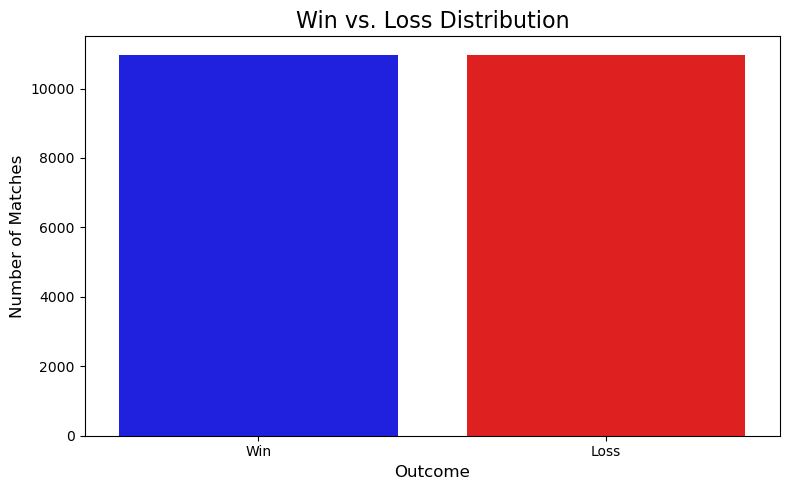

In [3]:
#Win Distribution Analysis
#explicitly map win values to categorical labels so they are centered nicely
df_filtered_cleaned['win_label'] = df_filtered_cleaned['win'].map({0: 'Loss', 1: 'Win'})

plt.figure(figsize=(8, 5))
sns.countplot(data=df_filtered_cleaned, x='win_label', hue='win_label', palette={'Loss': 'red', 'Win': 'blue'}, legend=False)

plt.title("Win vs. Loss Distribution", fontsize=16)
plt.xlabel("Outcome", fontsize=12)
plt.ylabel("Number of Matches", fontsize=12)
plt.tight_layout()
plt.show()



In [4]:
#Frequency Counts for champions and roles
champion_counts = df_filtered_cleaned['champion_name'].value_counts().reset_index()
champion_counts.columns = ['champion_name', 'count']
print("Champion Frequency Count:")
print(champion_counts.to_string(index=False))

print("\n" + "="*50 + "\n")

# Role frequency count
role_counts = df_filtered_cleaned['role'].value_counts().reset_index()
role_counts.columns = ['role', 'count']
print("Role Frequency Count:")
print(role_counts.to_string(index=False))


Champion Frequency Count:
champion_name  count
  MissFortune    423
      Caitlyn    421
         Jinx    411
         Lulu    405
        Viego    362
         Jhin    358
          Lux    345
   MonkeyKing    324
       Viktor    312
       Ezreal    299
     Vladimir    286
         Nami    276
     Katarina    252
        Yasuo    238
        Diana    233
        Janna    233
        Karma    232
       Thresh    227
    TahmKench    221
        Corki    218
       Syndra    217
       Twitch    217
       Darius    214
         Yone    212
     JarvanIV    208
        Sylas    205
        Vayne    196
  Mordekaiser    195
         Kayn    193
     Nocturne    192
     Volibear    190
        Kaisa    182
      Chogath    181
       Draven    179
         Ashe    178
       Irelia    177
        Kayle    170
        Amumu    169
      Hecarim    167
       LeeSin    167
        Garen    166
     Malzahar    163
        Milio    163
      Warwick    161
     Nautilus    159
        

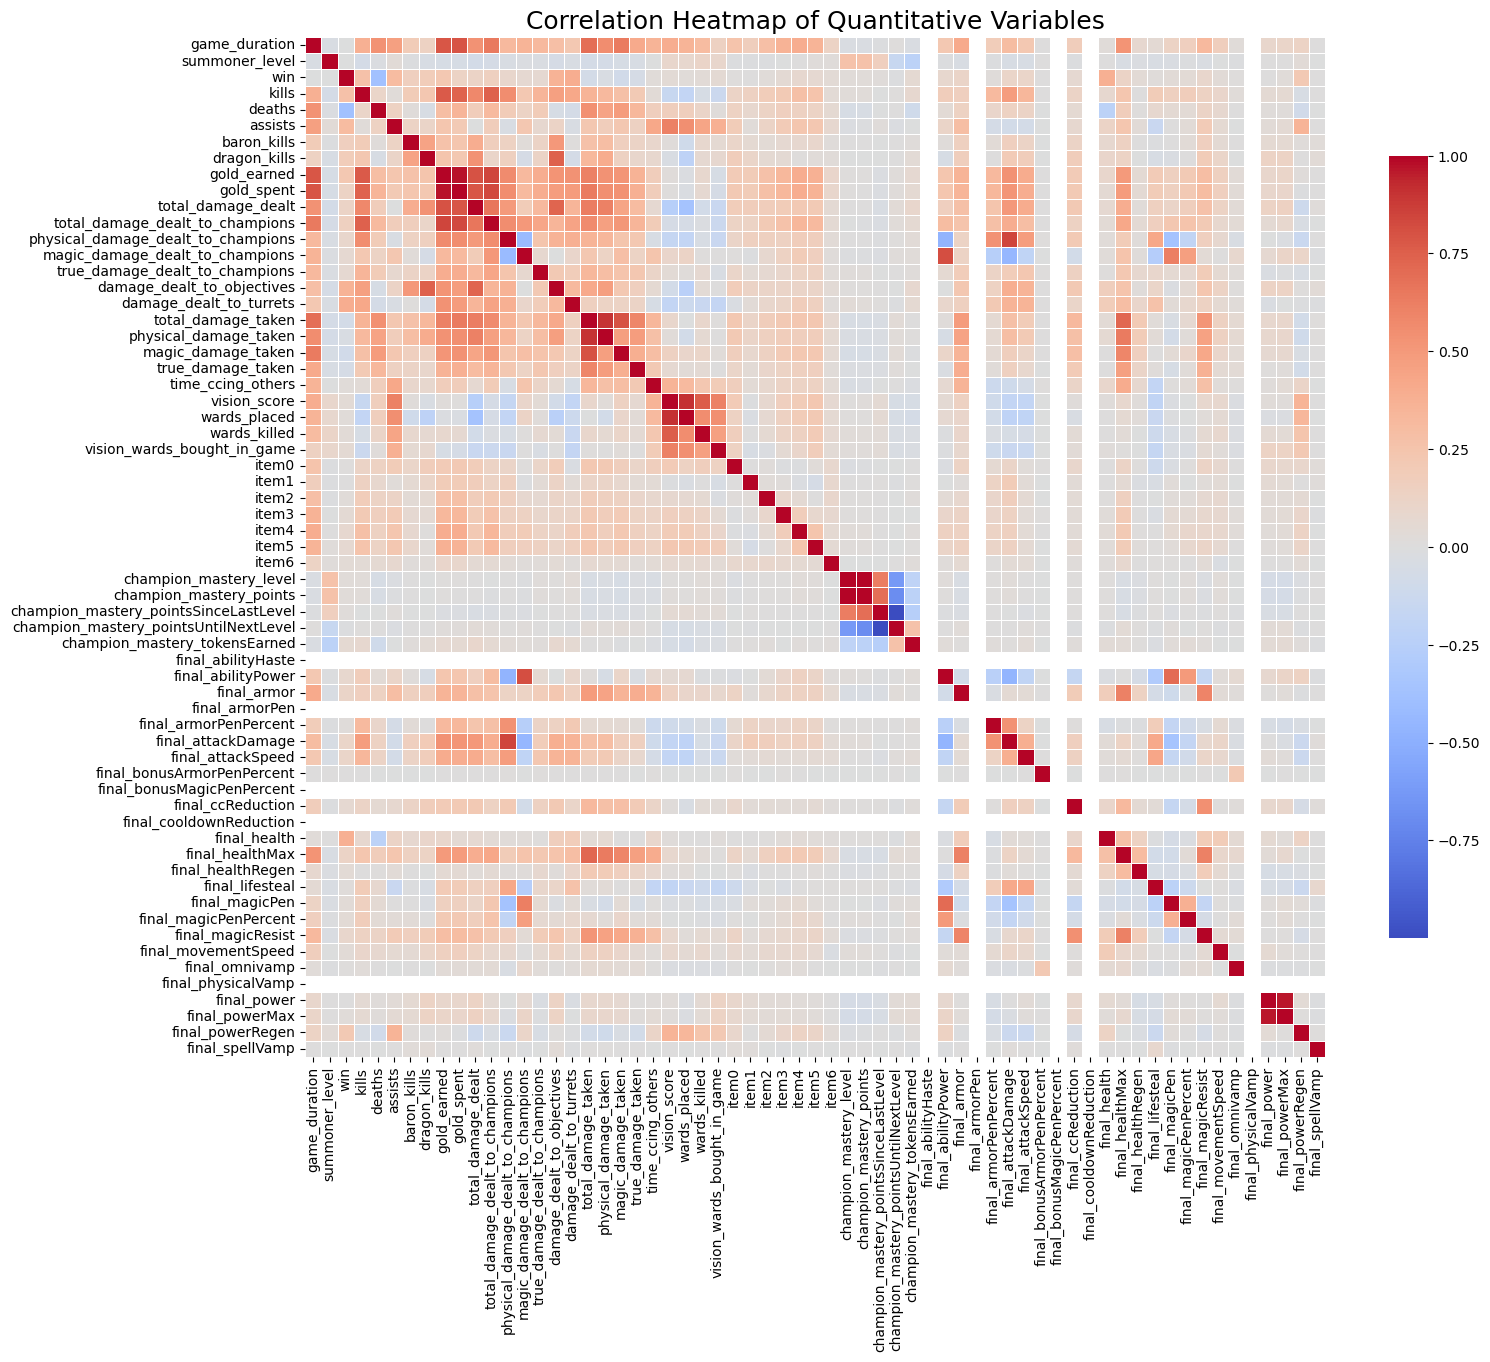

In [5]:
#Correlation Heatmap
#select quantitative (numeric) columns
quantitative_columns = df_filtered_cleaned.select_dtypes(include=['number']).columns

#compute the correlation matrix
correlation_matrix = df_filtered_cleaned[quantitative_columns].corr()

#plot the heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.7})

plt.title("Correlation Heatmap of Quantitative Variables", fontsize=18)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [6]:
#list correlated quantitative variables with correlation coefficient above 0.75
#set the threshold
threshold = 0.75

#get numeric columns
quantitative_columns = df_filtered_cleaned.select_dtypes(include=['number']).columns
correlation_matrix = df_filtered_cleaned[quantitative_columns].corr()

#find pairs with high absolute correlation
high_corr_pairs = [
    (col1, col2, correlation_matrix.loc[col1, col2])
    for i, col1 in enumerate(quantitative_columns)
    for j, col2 in enumerate(quantitative_columns)
    if i < j and abs(correlation_matrix.loc[col1, col2]) > threshold
]

#sort and print
high_corr_pairs_sorted = sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)

print("Highly Correlated Variable Pairs (|r| > 0.75):\n")
for var1, var2, corr in high_corr_pairs_sorted:
    print(f"{var1} ↔ {var2} | r = {corr:.3f}")


Highly Correlated Variable Pairs (|r| > 0.75):

champion_mastery_pointsSinceLastLevel ↔ champion_mastery_pointsUntilNextLevel | r = -1.000
champion_mastery_level ↔ champion_mastery_points | r = 0.996
gold_earned ↔ gold_spent | r = 0.975
final_power ↔ final_powerMax | r = 0.965
vision_score ↔ wards_placed | r = 0.914
total_damage_taken ↔ physical_damage_taken | r = 0.902
gold_earned ↔ total_damage_dealt_to_champions | r = 0.847
physical_damage_dealt_to_champions ↔ final_attackDamage | r = 0.846
gold_spent ↔ total_damage_dealt_to_champions | r = 0.835
magic_damage_dealt_to_champions ↔ final_abilityPower | r = 0.817
gold_earned ↔ total_damage_dealt | r = 0.800
total_damage_taken ↔ magic_damage_taken | r = 0.799
game_duration ↔ gold_spent | r = 0.789
gold_spent ↔ total_damage_dealt | r = 0.786
game_duration ↔ gold_earned | r = 0.784
kills ↔ gold_earned | r = 0.773
vision_score ↔ wards_killed | r = 0.764


In [7]:
#We will do PCA analysis, but first must determine if robust PCA is necessary.  So we need to check for outliers and skewed distributions.

In [8]:
#identify numeric columns
#item columns are numeric but categorical as they just use numbers to identify items
#this poses a problem for the PCA analysis: how to include categorical variables if desired?  There are methods.
quantitative_columns = df_filtered_cleaned.select_dtypes(include=['number']).columns
quantitative_data = df_filtered_cleaned[quantitative_columns]

#outlier detection using IQR method
outlier_info = []

for col in quantitative_data.columns:
    q1 = quantitative_data[col].quantile(0.25)
    q3 = quantitative_data[col].quantile(0.75)
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    outlier_count = ((quantitative_data[col] < lower_fence) | (quantitative_data[col] > upper_fence)).sum()
    outlier_info.append((col, outlier_count))

#format and display
outlier_df = pd.DataFrame(outlier_info, columns=['Variable', 'Outlier Count'])
outlier_df = outlier_df.sort_values(by='Outlier Count', ascending=False)

print("Outlier Count per Quantitative Variable:\n")
print(outlier_df.to_string(index=False))


Outlier Count per Quantitative Variable:

                             Variable  Outlier Count
                                item2           9119
                                item3           8673
                       final_magicPen           4808
                         dragon_kills           4778
                    final_ccReduction           4298
                     final_powerRegen           3458
                      final_lifesteal           3208
                    final_healthRegen           2906
                final_armorPenPercent           2849
              champion_mastery_points           2611
               champion_mastery_level           2585
                  final_movementSpeed           2400
                         vision_score           2378
                final_magicPenPercent           2123
champion_mastery_pointsUntilNextLevel           2070
champion_mastery_pointsSinceLastLevel           2007
                         wards_placed           2004
    

In [9]:
#remove all categorical variables from the data (object or category type)
df_numeric_only = df_filtered_cleaned.drop(columns=df_filtered_cleaned.select_dtypes(include=['object', 'category']).columns)

#drop item columns explicitly (even though are may be numeric, they are IDs)
item_columns = [col for col in df_numeric_only.columns if col.startswith("item")]
df_numeric_only = df_numeric_only.drop(columns=item_columns)

#recalculate outliers and skewness, high skewness is |skewness|>1
outlier_info = []
skewness_info = []

for col in df_numeric_only.columns:
    if col == 'win':
        continue
    q1 = df_numeric_only[col].quantile(0.25)
    q3 = df_numeric_only[col].quantile(0.75)
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    outlier_count = ((df_numeric_only[col] < lower_fence) | (df_numeric_only[col] > upper_fence)).sum()
    outlier_info.append((col, outlier_count))
    skew_val = skew(df_numeric_only[col].dropna())
    skewness_info.append((col, skew_val))

#format and display
outlier_df = pd.DataFrame(outlier_info, columns=['Variable', 'Outlier Count'])
skewness_df = pd.DataFrame(skewness_info, columns=['Variable', 'Skewness'])
eda_summary = pd.merge(outlier_df, skewness_df, on='Variable').sort_values(by='Outlier Count', ascending=False)

print("EDA Summary: Outlier Count and Skewness\n")
print(eda_summary.to_string(index=False))

EDA Summary: Outlier Count and Skewness

                             Variable  Outlier Count   Skewness
                       final_magicPen           4808   2.223273
                         dragon_kills           4778   2.484334
                    final_ccReduction           4298   1.845652
                     final_powerRegen           3458   2.292677
                      final_lifesteal           3208   3.010088
                    final_healthRegen           2906  20.659101
                final_armorPenPercent           2849   2.455695
              champion_mastery_points           2611   5.673979
               champion_mastery_level           2585   5.788931
                  final_movementSpeed           2400   2.164433
                         vision_score           2378   1.990228
                final_magicPenPercent           2123   5.023595
champion_mastery_pointsUntilNextLevel           2070  -5.279387
champion_mastery_pointsSinceLastLevel           2007   5.221366

In [10]:
#this will implement robust PCA manually, the single (!) Python library which performs this doesn't work as well as needed
# === STEP 1: Prepare the data ===
#drop the response column
X = df_numeric_only.drop(columns=['win'])
y = df_numeric_only['win']

#fill missing values with column means 
X_filled = X.fillna(X.mean())

#standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filled)

# === STEP 2: Manual Robust PCA (PCP Method) ===
#PCP is principal component pursuit
#L is low-rank approximation - "clean" signal, S is sparse matrix - outliers or anomalies

def robust_pca(M, max_iter=1000, tol=1e-7):
    def shrinkage_operator(x, tau):
        return np.sign(x) * np.maximum(np.abs(x) - tau, 0.)

    def svd_thresholding_operator(X, tau):
        U, S, Vh = LA.svd(X, full_matrices=False)
        S_thresh = shrinkage_operator(S, tau)
        return U @ np.diag(S_thresh) @ Vh

    S = np.zeros_like(M)
    Y = np.zeros_like(M)
    mu = np.prod(M.shape) / (4.0 * LA.norm(M, ord=1))
    mu_inv = 1.0 / mu
    lam = 1.0 / np.sqrt(np.max(M.shape))

    for _ in range(max_iter):
        L = svd_thresholding_operator(M - S + mu_inv * Y, mu_inv)
        S = shrinkage_operator(M - L + mu_inv * Y, lam * mu_inv)
        Y = Y + mu * (M - L - S)
        error = LA.norm(M - L - S, ord='fro')
        if error < tol:
            break

    return L, S

#run Robust PCA
L, S = robust_pca(X_scaled)

# === STEP 3: Inspect results ===
print("Manual Robust PCA Complete")
print(f"Low-rank matrix shape: {L.shape}")
print(f"Sparse outlier matrix shape: {S.shape}")
print(f"Frobenius norm of S (outlier strength): {np.linalg.norm(S, 'fro'):.2f}")



Manual Robust PCA Complete
Low-rank matrix shape: (21910, 55)
Sparse outlier matrix shape: (21910, 55)
Frobenius norm of S (outlier strength): 229.27


Number of components to reach 80% variance: 14


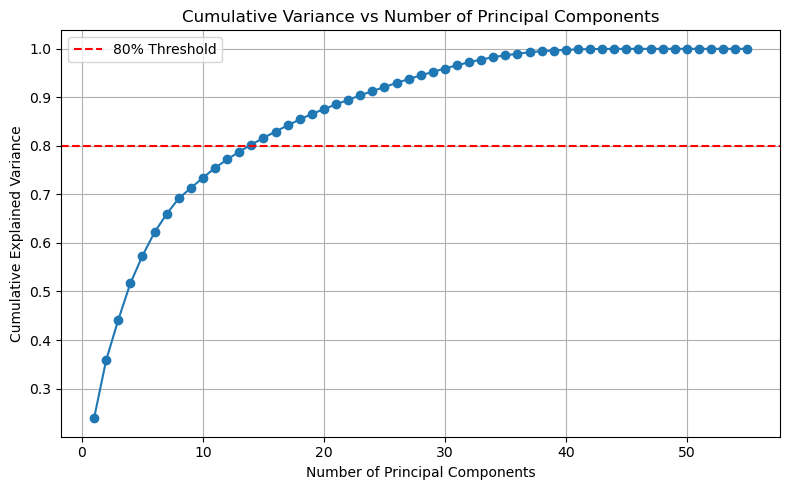

Robust PCA + Logistic Regression Results
Accuracy:  0.8352
F1 Score:  0.8351
ROC AUC:   0.9092


In [11]:
#takes L matrix from robust PCA and puts it into logistic regression function
# === Step 1: Apply PCA to the low-rank matrix (L from robust_pca)
pca_robust = PCA()
L_pca = pca_robust.fit_transform(L)

# === Step 2: Determine number of PCs to capture ≥80% variance
cumulative_variance = np.cumsum(pca_robust.explained_variance_ratio_)
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1
print(f"Number of components to reach 80% variance: {n_components_80}")

#also show plot of number of principal components vs cumulative variance with 80% threshold line
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Variance vs Number of Principal Components')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Step 3: Use those components for logistic regression
X_pca_80 = L_pca[:, :n_components_80]

X_train, X_test, y_train, y_test = train_test_split(X_pca_80, y, test_size=0.3, stratify=y)

log_reg = LogisticRegression(penalty=None, max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

# === Step 4: Evaluate performance
print("Robust PCA + Logistic Regression Results")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.4f}")


In [12]:
#validates Robust PCLR model via shuffle test and k fold cross validation
# =========================
# Shuffle Test
# =========================
_, y_shuffled = shuffle(X_pca_80, y)

X_train, X_test, y_train_shuff, y_test_shuff = train_test_split(
    X_pca_80, y_shuffled, test_size=0.3, stratify=y_shuffled
)

logreg_rpclr_shuff = LogisticRegression(penalty=None, max_iter=1000)
logreg_rpclr_shuff.fit(X_train, y_train_shuff)
y_proba_shuff = logreg_rpclr_shuff.predict_proba(X_test)[:, 1]

print("RPCLR (80% variance PCs) – Shuffle Test")
print(f"ROC AUC (Shuffled): {roc_auc_score(y_test_shuff, y_proba_shuff):.4f}\n")

# =========================
# 5-Fold Cross-Validation
# =========================
kf = StratifiedKFold(n_splits=5, shuffle=True)
auc_scores = []

for train_index, test_index in kf.split(X_pca_80, y):
    X_train, X_test = X_pca_80[train_index], X_pca_80[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = LogisticRegression(penalty=None, max_iter=1000)
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    auc_scores.append(auc)

print("RPCLR (80% variance PCs) – 5-Fold Cross-Validation")
print("AUCs:", np.round(auc_scores, 4))
print(f"Mean AUC: {np.mean(auc_scores):.4f} | Std Dev: {np.std(auc_scores):.4f}")


RPCLR (80% variance PCs) – Shuffle Test
ROC AUC (Shuffled): 0.5090

📊 RPCLR (80% variance PCs) – 5-Fold Cross-Validation
AUCs: [0.9052 0.9048 0.9098 0.9085 0.9095]
Mean AUC: 0.9076 | Std Dev: 0.0021
